In [5]:
from dask.distributed import Client, LocalCluster, wait
from distributed.diagnostics import MemorySampler

import dask.dataframe as dd
import numpy as np

In [6]:
# Set up local cluster and output dashboard link.
cluster = LocalCluster(memory_limit="auto", processes=True)
client = Client(cluster)
ms = MemorySampler()
cluster

/Users/denysmelnychenko/opt/anaconda3/envs/env/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49505 instead
  f"Port {expected} is already in use.\n"


LocalCluster(bc37eb4f, 'tcp://127.0.0.1:49506', workers=4, threads=4, memory=8.00 GiB)

In [7]:
# Explicitly declare feature types.
feature_names = [f'feature_type_1_{i}' for i in range(0,10)]
type_dict = dict(zip(feature_names, [np.float32]*len(feature_names)))
type_dict

{'feature_type_1_0': numpy.float32,
 'feature_type_1_1': numpy.float32,
 'feature_type_1_2': numpy.float32,
 'feature_type_1_3': numpy.float32,
 'feature_type_1_4': numpy.float32,
 'feature_type_1_5': numpy.float32,
 'feature_type_1_6': numpy.float32,
 'feature_type_1_7': numpy.float32,
 'feature_type_1_8': numpy.float32,
 'feature_type_1_9': numpy.float32}

In [8]:
# Add dataframe reading to DAG.
train_df = dd.read_csv('big_train.csv', dtype=type_dict, usecols=feature_names, blocksize="64MB")
test_df = dd.read_csv('big_test.csv', dtype=type_dict, usecols=["id_job"]+feature_names, blocksize="64MB")

In [9]:
# Several things will happen here:
# 1) train_df will be uploaded to cluster memory in chunks
# 2) mean statistic will be calculated on it's cols
# Since output of mean() is fairly small memory-vise it is save to run calculate() and store it in RAM.
%%time
train_mean = train_df.mean().compute()
train_mean

CPU times: user 29.4 s, sys: 4.96 s, total: 34.4 s
Wall time: 1min 23s


feature_type_1_0    0.739114
feature_type_1_1    0.736033
feature_type_1_2    0.792562
feature_type_1_3    0.746938
feature_type_1_4    0.854326
feature_type_1_5    0.887924
feature_type_1_6    0.845099
feature_type_1_7    0.790395
feature_type_1_8    0.761327
feature_type_1_9    0.777028
dtype: float64

In [10]:
# Similarly to last step we calculate standart deviation. 
# This time train_df won't be loading since it is already loaded to memory.
%%time
train_std = train_df.std().compute()
train_std

CPU times: user 30.6 s, sys: 5.18 s, total: 35.8 s
Wall time: 1min 28s


feature_type_1_0    0.100149
feature_type_1_1    0.118220
feature_type_1_2    0.138388
feature_type_1_3    0.119605
feature_type_1_4    0.091687
feature_type_1_5    0.115303
feature_type_1_6    0.109548
feature_type_1_7    0.094293
feature_type_1_8    0.111961
feature_type_1_9    0.090286
dtype: float32

In [11]:
# Since we calculated everything we need from train_df - we delete it from cluster memory.
client.cancel(train_df)

In [12]:
# Add vectorized z-score calculation to DAG. 
# Round floats because our output format is .csv and high precision 
# leads to lot's of symbils and, hence, to .csv bloating.  
test_df[feature_names] = (test_df[feature_names] - train_mean) / train_std
test_df[feature_names] = test_df[feature_names].round(4)

In [13]:
# Create name to index dimension mappings.
feature_1_dimension_id = list(map(lambda x: x.split("_")[-1], feature_names))
feature_1_rename_dict = dict(zip(feature_names, feature_1_dimension_id))
feature_1_reverse_rename_dict = dict(zip(feature_1_dimension_id, feature_names))
feature_1_reverse_rename_dict

{'0': 'feature_type_1_0',
 '1': 'feature_type_1_1',
 '2': 'feature_type_1_2',
 '3': 'feature_type_1_3',
 '4': 'feature_type_1_4',
 '5': 'feature_type_1_5',
 '6': 'feature_type_1_6',
 '7': 'feature_type_1_7',
 '8': 'feature_type_1_8',
 '9': 'feature_type_1_9'}

In [14]:
# Create new column containing index of dimension with maximum value. 
test_df = test_df.rename(columns=feature_1_rename_dict)
test_df["max_feature_type_1_index"] = test_df[feature_1_dimension_id].idxmax(axis=1)
test_df = test_df.rename(columns=feature_1_reverse_rename_dict)

In [15]:
# Output DAG description.
test_df.dask

HighLevelGraph with 53 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7fa52a69e290>
 0. from_pandas-67cad7b18293d6c2d7ea327d097443aa
 1. from_pandas-94d2ba6a488898ee8a8d04ffcd1aec1a
 2. read-csv-1cbbfb133dc9a624ea9726841749b929
 3. getitem-02e1dfd45a99d02221810d9a371f8668
 4. sub-655e0aaf59452618e731fdb32909af0b
 5. truediv-7a5cfd79fa528926fb25ce4b9427b618
 6. getitem-fcfdc27012b1523fd28455ececa4b8b2
 7. getitem-13c6136c0e2970aa3b0aebfedfa2072c
 8. getitem-133712a75d74df0e836eac3122df4476
 9. getitem-d6e5282d64799dfb935e996885f35b3b
 10. getitem-632c7bec8530a819b45662e2a6774ebb
 11. getitem-ef069a09962bd47321d6e0d5b8914efc
 12. getitem-8d05a8149ea4c0d71d763e27a1322a49
 13. getitem-43e2e436a62e3f5c830115ffc2e5433b
 14. getitem-2599ee7b49b296d60ae5e62bc9468529
 15. getitem-2ca6920b09be8a7e64ee0a9333403c28
 16. assign-58ce2378d0d37334be91ca0551f92a4c
 17. assign-fdef702edd7d80f01a7abadfbfdacf4d
 18. assign-1b7852a0e85dca971bae082c7a6806c5
 19. assign-e05410026b268a37a15620b1ab1533de
 20. assign-bd5a5597f85a918f95b4d31e92a3ec9f
 21. assign-b8a96356a19d77cd8b79e5491acf9c5d
 22. assign-7813eca19f5e1eca4947be3869e380da
 23. assign-f6ac0f97e5b58cf779e5106946f096b6
 24. assign-18de70a925636a11913a57df4a1f9e28
 25. assign-0fb8bdb008395782f05156098e0f34ba
 26. getitem-4624f05a386ccf3d32f40136c4eab873
 27. round-419351fc7c2e71306bed16acbda04523
 28. getitem-af65e86544988c98dd74f5d379629c7d
 29. getitem-51136347a230cce311e0e90894e51d16
 30. getitem-3a7ec055bc2bfbe789faac024709ea92
 31. getitem-90f65c3d89995ba6ca12e75ad836e5d0
 32. getitem-55ca5120b6ca037e7c8137039441a406
 33. getitem-426be86ec997b3b959b8fc7c4f26a79a
 34. getitem-3058f2c7d08746b0e9d116f8f7cf5f14
 35. getitem-a2f35061592cf2f67f4ef6d2d7ed8557
 36. getitem-f723991ae28489e6811322f3ff76ed21
 37. getitem-67dcf17f9b03af4d1060eef621e58e31
 38. assign-8dfb315f3123d81a80aaf2614d7de39e
 39. assign-3193855009ec93e358c65ce96bed1fc9
 40. assign-b31fe358a098b29d01c8485c04237054
 41. assign-c212ff5e2e30bb1afd10bcb260e64a95
 42. assign-374d4e2c0ac917f72ea9c75ccdf0efe7
 43. assign-6bfe31aa5a80d445ac281138c2728057
 44. assign-94e349fb1005db37a67b6c18675133db
 45. assign-10fba2ebf1b088c31e2af738cfe2398f
 46. assign-c76ad1d732b19a3d350a6028db81cce9
 47. assign-2e7667cba5a2d18ed296bf545098d604
 48. rename-03baa3f50841ea5b344efd695f6d0432
 49. getitem-4ba245f0a204866fa10db3d63f5f63db
 50. dataframe-idxmax-b8039c7bccc0922c075d42b939277d44
 51. assign-cb0d11d08b5ff6c70bca28be3eed69df
 52. rename-e4ea58b723fb1ae63776e138e6b800e3

In [16]:
# Execute DAG by writing it's results to .csv file.
%%time
with ms.sample("z-score computation"):
    test_df.to_csv('./big_test_transformed.csv', single_file=True)

CPU times: user 5min 48s, sys: 1min 5s, total: 6min 54s
Wall time: 23min 24s


<AxesSubplot:xlabel='time', ylabel='Cluster memory (GiB)'>

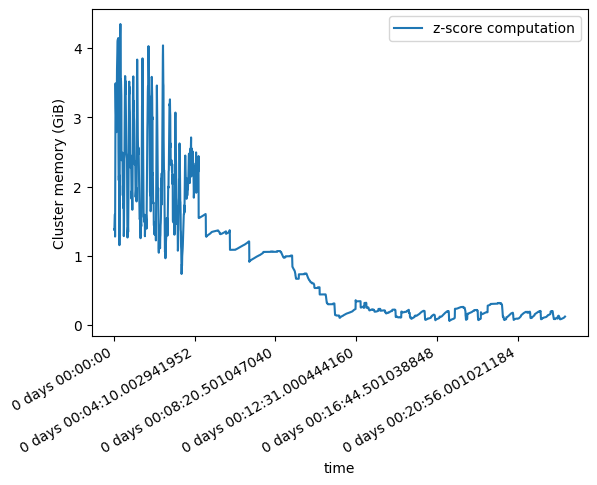

In [17]:
# Plot cluster memory usage.
ms.plot(align=True)

In [18]:
# Delete test_df from cluster memory.
client.cancel(test_df)

In [22]:
# Output head of resulting .csv.
transformed_train_df = dd.read_csv('big_test_transformed.csv', blocksize="64MB")
transformed_train_df.head()

,Unnamed: 0,id_job,feature_type_1_0,feature_type_1_1,feature_type_1_2,feature_type_1_3,feature_type_1_4,feature_type_1_5,feature_type_1_6,feature_type_1_7,feature_type_1_8,feature_type_1_9,max_feature_type_1_index
0,0,-62417222087235558851,1.8751,1.6602,0.8992,1.1510,1.0947,0.6832,0.9055,1.2409,1.5816,1.3864,0
1,1,-50963178928536939691,-0.5673,-0.5772,-1.2773,-1.3364,0.3335,-0.5457,-5.0079,0.1114,-1.7107,-0.2196,4
2,2,29967041948702897681,-1.0186,0.1317,0.7489,0.7480,-0.3046,0.2721,0.6490,0.7965,0.0560,0.5313,7
3,3,-54412919407735587651,0.7068,1.0300,0.6846,0.9202,0.7337,0.3719,0.6509,1.2207,0.1784,1.2978,9
4,4,36626971604780743751,-0.3007,0.0649,-1.7585,-1.1784,-0.3384,-0.1069,-6.4246,-0.1071,-1.4061,0.0362,1
